In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import zipfile
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
from ModelStructures import select_model
from math import floor, ceil

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

In [ ]:
# Load our best model
# Grozi
n_param_g = 80
m_grozi, tform_grozi = select_model('resnet', n_param_g, 'SGD', test=True)
m_load = torch.load('./Testing Models/AMATH563_Project_resnet_Grozi_trained.pth')
m_grozi.load_state_dict(m_load)

<All keys matched successfully>

In [ ]:
# Read in Data
image_scenes = pd.read_csv('final_box_labels_grozi.csv')
image_scenes['image_id'] = pd.factorize(image_scenes['image_path'])[0] # Encode file to integer

# Create data sets
scene_ids = image_scenes['image_id'].unique()
scenes_copy = image_scenes.copy() # For filtering
random.Random(1).shuffle(scene_ids)
train_ids = scene_ids[:len(scene_ids)-80]
train_scenes = scenes_copy[scenes_copy['image_id'].isin(train_ids)]
val_scenes = scenes_copy[~scenes_copy['image_id'].isin(train_ids)]
print(len(train_scenes.index), len(val_scenes.index))

2363 305


In [ ]:
# Set up Model
weight_update = True # Using our classifier weights
req_grad = True # Parameter for if we freeze our weights (Does nothing if weight update is false)
pre_train = True # Parameter for if we pre-train
train_backbone_layers = 5 # How many backbone layers do we want to train?

# Make Path
f_path = './Detection/Archive/' + 'ourweights=' + str(weight_update) + \
            '_reqgrad=' + str(req_grad) + '_pretrain=' + str(pre_train) + '/'

if not os.path.exists(f_path):
    os.makedirs(f_path)

# Load base model
m_detect = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pre_train,
                                                                progress=False,
                                                                pretrained_backbone=False,
                                                                trainable_backbone_layers=train_backbone_layers)

in_features = m_detect.roi_heads.box_predictor.cls_score.in_features
m_detect.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_param_g + 1)

# Extract the weights from our model
if weight_update:
    weight_dict = {}
    for name, value in m_grozi.named_parameters():
        weight_dict[name] = value

    # Update weights in backbone
    with torch.no_grad():
        for name, param in m_detect.backbone.body.named_parameters():
            param = weight_dict[name]
            param.requires_grad = req_grad
    
# Update image size
m_detect.transform.max_size = 3264 # Update max size

In [ ]:
# Custom image dataset
class DetectionImageDataset():
    def __init__(self, image_frame, transforms, new_biggest_dim=None, short=False):
        self.image_frame = image_frame
        self.transforms = transforms        
        self.images = self.image_frame['image_path'].unique()
        self.new_biggest_dim = new_biggest_dim
        self.short = short
        
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path) # Open the image
        width, height = img.size # Get size of image
        scaler_width, scaler_height = 1, 1
        
        if not self.short:
            if self.new_biggest_dim:
                assert isinstance(self.new_biggest_dim, int)
                if width > height:
                    new_width = self.new_biggest_dim
                    new_height = floor(height * new_width / width)
                else:
                    new_height = self.new_biggest_dim
                    new_width = floor(width * new_height / height)

                img = img.resize((new_width, new_height))

                # Scalers for adjusting bounding boxes
                scaler_width = new_width / width
                scaler_height = new_height / height
        
        # Match Paper
        elif self.short:
            if width < height:
                new_width = 600
                new_height = floor(height * new_width / width)
            else:
                new_height = 600
                new_width = floor(width * new_height / height)
                
            img = img.resize((new_width, new_height))

            # Scalers for adjusting bounding boxes
            scaler_width = new_width / width
            scaler_height = new_height / height
        
        image_labels = self.image_frame[self.image_frame['image_path'] == \
                                       img_path]
        
        # Get all the boxes and labels
        boxes = []
        labels = []
        for idx, row in image_labels.iterrows():
            x_min = row['bbox_x'] * width * scaler_width
            x_max = row['bbox_w'] * width * scaler_width
            y_min = row['bbox_y'] * height * scaler_height
            y_max = row['bbox_h'] * height * scaler_height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(row['label'])
        
        image_id = image_labels['image_id'].unique()
        
        # Convert everything to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64) # Assume all instances are not crowd
        image_id = torch.as_tensor(image_id)
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # Generate targets dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = areas
        target['iscrowd'] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
        
    def __len__(self):
        return len(self.images)

In [ ]:
# Import transforms helper
import transforms as T
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transforms)

# Parameters for dimensions
n_dim = None
short_bool = False

# Datasets
train_set = DetectionImageDataset(train_scenes, transforms=get_transform(True), new_biggest_dim=n_dim,
                                 short=short_bool)
val_set = DetectionImageDataset(val_scenes, transforms=get_transform(False), new_biggest_dim=n_dim,
                               short=short_bool)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True,
                                          pin_memory=True, num_workers=0,
                                          collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False,
                                          pin_memory=True, num_workers=0,
                                        collate_fn=utils.collate_fn)

In [ ]:
# Unzip images
if not os.path.exists('./Testing'):
    test_zipped = zipfile.ZipFile('./Testing.zip', 'r')
    test_zipped.extractall()
    test_zipped.close()

In [ ]:
# Import needed items
from engine import train_one_epoch, evaluate

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 40 if pre_train else 50 # More epochs if not pre-training
step_size = 2 * num_epochs / 10 
patience = 20 # For early stopping
patience_steps = 5 # If we don't improve, stop early
counter = 0

# Model, Optimizer, Parameters
m_detect.to(device)
scheduler = 'plateau'
params = [p for p in m_detect.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-2,
                            momentum=0.9, weight_decay=0.0005)


if scheduler != 'step':
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                             mode='min',
                                                             patience=2,
                                                             cooldown=1,
                                                             min_lr=1e-6)
else:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                  step_size=step_size,
                                                  gamma=0.1)

In [ ]:
# Train!
min_train_loss = (0, 1000, None) # Epoch, Loss, Path for best performing train loss
min_val_loss = (0, 1000, None) # Epoch, loss, path for best performing val loss
loss_data = []
val_loss_data = []
map_50 = []
recall_data = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    t = train_one_epoch(m_detect, optimizer, train_loader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    m, l = evaluate(m_detect, val_loader, device=device)
    # Save checkpoints
    if not os.path.exists('./Detection/Checkpoints/'):
        os.makedirs('./Detection/Checkpoints')
        
    cpt_path = './Detection/Checkpoints/chkpt_' + str(epoch+1) + '_training.pt'
    torch.save({'epoch':epoch+1,
                'model_state_dict':m_detect.state_dict(),
               'optimizer_state_dict':optimizer.state_dict(),
                'loss_data':loss_data,
                'val_loss_data':val_loss_data,
                'map_50':map_50,
                'recall_data':recall_data,
               'counter':counter},
               cpt_path)
    
    # update the learning rate
    if lr_scheduler:
#         if lr_scheduler.get_last_lr()[0] > 1e-6: # Set minimum learning rate
        if scheduler != 'plateau':
            lr_scheduler.step()
        else:
            lr_scheduler.step(l.loss.value)
    
    if t.loss.value < min_train_loss[1]:
        min_train_loss = (epoch, t.loss.value, cpt_path)
    
    if l.loss.value < min_val_loss[1]:
        min_val_loss = (epoch, l.loss.value, cpt_path)
        counter = 0 # Reset counter as we have made progress
    
    # Append losses
    loss_data.append(t.loss.value)
    val_loss_data.append(l.loss.value)
    
    # Metrics
    for k, v in m.coco_eval.items():
        map_50.append(v.stats[1])
        recall_data.append(v.stats[-1])
        
    # Early stopping
    if epoch + 1 > patience and l.loss.value > min_val_loss[1]:
        counter += 1
        if counter > patience_steps:
            print('Terminated training at epoch=' + str(epoch))
            break

Epoch: [0]  [  0/300]  eta: 0:14:12  lr: 0.000043  loss: 5.1598 (5.1598)  loss_classifier: 4.4342 (4.4342)  loss_box_reg: 0.6460 (0.6460)  loss_objectness: 0.0507 (0.0507)  loss_rpn_box_reg: 0.0288 (0.0288)  time: 2.8416  data: 1.1003  max mem: 3849
Epoch: [0]  [ 10/300]  eta: 0:07:06  lr: 0.000378  loss: 4.6867 (4.5144)  loss_classifier: 4.1921 (3.9571)  loss_box_reg: 0.5019 (0.4868)  loss_objectness: 0.0324 (0.0444)  loss_rpn_box_reg: 0.0251 (0.0261)  time: 1.4692  data: 0.7813  max mem: 4119
Epoch: [0]  [ 20/300]  eta: 0:06:20  lr: 0.000712  loss: 2.6285 (3.2682)  loss_classifier: 1.9535 (2.7018)  loss_box_reg: 0.5019 (0.5069)  loss_objectness: 0.0292 (0.0352)  loss_rpn_box_reg: 0.0235 (0.0243)  time: 1.2860  data: 0.7035  max mem: 4119
Epoch: [0]  [ 30/300]  eta: 0:06:00  lr: 0.001046  loss: 1.6866 (2.6946)  loss_classifier: 1.0299 (2.1264)  loss_box_reg: 0.5108 (0.5092)  loss_objectness: 0.0160 (0.0298)  loss_rpn_box_reg: 0.0205 (0.0292)  time: 1.2598  data: 0.6768  max mem: 4119


Best Scenario: (16, 0.4428667426109314, './Detection/Checkpoints/chkpt_17_training.pt')


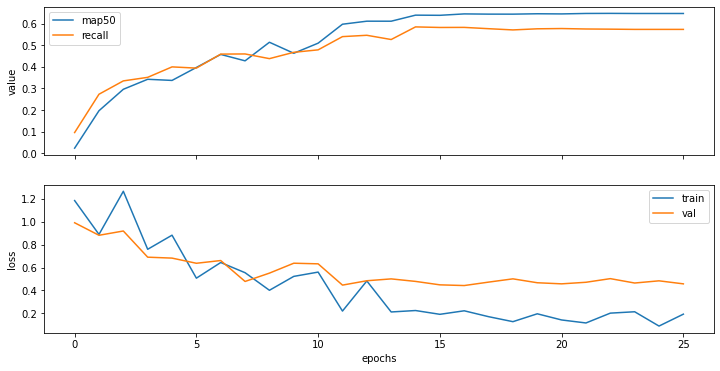

In [ ]:
# Save out trained model, loss curves, accuracies
print('Best Scenario: ' + str(min_val_loss))

f_path = f_path + scheduler + '/' # Add scheduler to path

if not os.path.exists(f_path):
        os.makedirs(f_path)

# Write Out Data
epoch_array = np.arange(0, epoch + 1)
loss_data = np.array(loss_data)
val_loss_data = np.array(val_loss_data)
map_50 = np.array(map_50)
recall_data = np.array(recall_data)

data_df = pd.DataFrame({'epoch':epoch_array,
                       'train_loss':loss_data,
                        'val_loss':val_loss_data,
                       'map50':map_50,
                       'recall':recall_data})

# Write out data
data_df.to_csv(f_path + 'AMATH563_Project_TrainedDetector.csv')

# Plot Results
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(map_50)
ax1.plot(recall_data)
ax1.set_ylabel("value")
ax1.legend(['map50', 'recall'])
ax2.plot(loss_data)
ax2.plot(val_loss_data)
ax2.legend(['train', 'val'])
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")
plt.savefig(f_path + 'AMATH563_Grozi_Detection_Final.png')

# Save final
model_path = f_path + 'AMATH563_Grozi_Detection_Final.pth'
torch.save(m_detect, model_path)

# Save Best - test_loss
model_path = f_path + 'AMATH563_Grozi_Detection_Best.pth'
best_performing = torch.load(min_val_loss[2])
m_detect.load_state_dict(best_performing['model_state_dict'])
torch.save(m_detect.state_dict(), model_path)

In [ ]:
# Clear out old checkpoints
import glob
for f in glob.glob('./Detection/Checkpoints/' + '*.pt'):
    os.remove(f)